In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score

IMGS_DIR = './images'

print('Imports Done')

Using TensorFlow backend.


Imports Done


In [7]:
TRAIN_DIR = os.path.join(IMGS_DIR, 'Train')
TEST_DIR = os.path.join(IMGS_DIR, 'Test')
VALID_DIR = os.path.join(IMGS_DIR, 'Valid')

In [6]:
# data prep

WIDTH = 299
HEIGHT = 299

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=False,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),batch_size=3,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=3,
    class_mode='categorical')

NameError: name 'TRAIN_DIR' is not defined

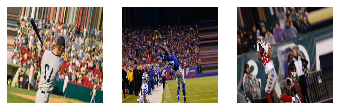

In [5]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch[0:24], y_batch[0:24])):
    plt.subplot(4, 6, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

In [3]:
# set up base model
base_model = Xception(weights='imagenet', include_top = False)

# Make all layers untrainable
for layer in base_model.layers:
    layer.trainable = False
    
# Open select bottom layers for training
num_trainable = 10
for layer in base_model.layers[-num_trainable:]:
    layer.trainable = True

# Dense Layers and output
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D(name = 'avg_pool'))
model.add(Dense(64, kernel_initializer='uniform', activation = 'relu'))
model.add(Dense(32, kernel_initializer='uniform', activation = 'relu'))
model.add(Dense(16, kernel_initializer='uniform', activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

model.compile(optimizer = Adam(.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [7]:
EPOCHS = 100
STEPS_PER_EPOCH = 50
VALIDATION_STEPS = 10

checkpointer = ModelCheckpoint(filepath='best_hdf5', 
                               verbose=1, save_best_only=True, monitor = 'val_loss')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10)

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    verbose = 1,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    callbacks=[checkpointer, es])

Epoch 1/100
50/50 [==============================] - 8s 159ms/step - loss: 0.5307 - accuracy: 0.7635 - val_loss: 2.3135 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 2.31351, saving model to best_hdf5
Epoch 2/100
50/50 [==============================] - 3s 70ms/step - loss: 0.2729 - accuracy: 0.8986 - val_loss: 12.1748 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 2.31351
Epoch 3/100
50/50 [==============================] - 3s 64ms/step - loss: 0.4004 - accuracy: 0.8784 - val_loss: 0.3714 - val_accuracy: 0.7000

Epoch 00003: val_loss improved from 2.31351 to 0.37137, saving model to best_hdf5
Epoch 4/100
50/50 [==============================] - 3s 63ms/step - loss: 0.2154 - accuracy: 0.9392 - val_loss: 0.3570 - val_accuracy: 0.9643

Epoch 00004: val_loss improved from 0.37137 to 0.35699, saving model to best_hdf5
Epoch 5/100
50/50 [==============================] - 3s 64ms/step - loss: 0.1682 - accuracy: 0.9595 - val_loss: 0.5932 - val_accuracy

In [4]:
model.load_weights('best_hdf5')
print(history.history)

def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

NameError: name 'history' is not defined

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0.9661016949152542

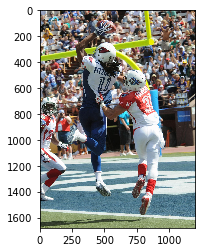

In [8]:
#Create a single test set from all of the test directories
from keras.preprocessing import image
from keras.models import load_model

X = []
X_p = []
Y = []
files = []
image_name = []
def make_train_data(DIR,label):
    for img in os.listdir(DIR):
        path = os.path.join(DIR,img)
        if path.endswith('.jpg'):
            img = image.load_img(path, target_size=(HEIGHT, WIDTH))
            img_p = Image.open(path).convert('RGB')
            x = image.img_to_array(img)
            #x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            X.append(np.array(x))
            Y.append(label)
            X_p.append(np.array(img_p))
            files.append(path)
            image_name.append(path.split('/')[-1])
            
make_train_data('./images/Test/Football', 1)
make_train_data('./images/Test/Baseball', 0)

X=np.array(X)
X_p=np.array(X_p)


predicts = model.predict(X)
plt.imshow(X_p[0])
predicts = np.argmax(predicts, axis=1)
print(predicts)
print(Y)

accuracy_score(Y, predicts)